# EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import json

import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [3]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_audited_fname = config['DEFAULT']['dataset_audited_fname']
dataset_EDA_fname = config['DEFAULT']['dataset_EDA_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [ ]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_audited_fname) + dataset_fname_suffix, header = 0, delimiter = ',',)

In [5]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658446 entries, 0 to 658445
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   EventName          658446 non-null  object 
 1   StartDate          658446 non-null  object 
 2   EventType          658446 non-null  object 
 3   BookingReference   658446 non-null  object 
 4   AttendeeReference  658446 non-null  object 
 5   GroupSize          658446 non-null  int64  
 6   IsLeadAttendee     658446 non-null  object 
 7   AttendeeGrossCost  658446 non-null  float64
 8   EventId            658446 non-null  int64  
 9   BookingStatus      658446 non-null  object 
 10  AttendeeType       658446 non-null  object 
 11  StatusCreatedDate  658444 non-null  object 
 12  ClientId           658446 non-null  float64
 13  StartYear          658446 non-null  int64  
 14  StatusCreatedYear  658444 non-null  float64
dtypes: float64(3), int64(3), object(9)
memory usage: 75

In [6]:
client_data.head(3)

,EventName,StartDate,EventType,BookingReference,AttendeeReference,GroupSize,IsLeadAttendee,AttendeeGrossCost,EventId,BookingStatus,AttendeeType,StatusCreatedDate,ClientId,StartYear,StatusCreatedYear
0,Developing Reading and Writing Skills,2017-11-28 00:00:00,"Others, Group 1",B462687,A514297,1,True,0.0,14983,Attending,Attendee,2017-11-11 09:15:00,153.0,2017,2017.0
1,Teaching Grammar: Classroom choices,2017-12-13 00:00:00,"Others, Group 1",B462689,A514299,1,True,0.0,14960,Attending,Attendee,2017-11-11 09:18:00,153.0,2017,2017.0
2,Teaching Grammar: Classroom choices,2017-12-13 00:00:00,"Others, Group 1",B467150,A519135,1,True,0.0,14960,Attending,Attendee,2017-11-22 17:02:00,153.0,2017,2017.0


In [7]:
client_data['StartDate'] = pd.to_datetime(client_data['StartDate'], infer_datetime_format=True)
client_data['StatusCreatedDate'] = pd.to_datetime(client_data['StatusCreatedDate'], infer_datetime_format=True)

In [8]:
# Creating the Season column
_condition_winter = (client_data.StartDate.dt.month>=1)&(client_data.StartDate.dt.month<=3)
_condtion_spring = (client_data.StartDate.dt.month>=4)&(client_data.StartDate.dt.month<=6)
_condition_summer = (client_data.StartDate.dt.month>=7)&(client_data.StartDate.dt.month<=9)
_condition_autumn = (client_data.StartDate.dt.month>=10)&(client_data.StartDate.dt.month<=12)
client_data['Season'] = np.where(_condition_winter,'Winter',np.where(_condtion_spring,'Spring',np.where(_condition_summer,'Summer',np.where(_condition_autumn,'Autumn',np.nan))))

In [9]:
# import pandas as pd
# import numpy as np
# StartDate1 ='2017-11-28'
# StartDate = pd.to_datetime(StartDate1)

#     # Creating the Season column
# _condition_winter = (StartDate.month>=1)&(StartDate.month<=3)
# _condtion_spring = (StartDate.month>=4)&(StartDate.month<=6)
# _condition_summer = (StartDate.month>=7)&(StartDate.month<=9)
# _condition_autumn = (StartDate.month>=10)&(StartDate.month<=12)
# Season = np.where(_condition_winter,'Winter',np.where(_condtion_spring,'Spring',np.where(_condition_summer,'Summer',np.where(_condition_autumn,'Autumn',np.nan))))

# if Season == 'Autumn':
#     Season = 0 
# elif Season == 'Winter':
#     Season = 3
# elif Season == 'Spring':
#     Season = 1 
# elif Season == 'Summer':
#     Season = 2 

# print(Season)

In [10]:
# Creating Days to Event
client_data['Days to Event'] = (client_data['StartDate'] - client_data['StatusCreatedDate']).dt.days 

In [11]:
client_data.head(3)

,EventName,StartDate,EventType,BookingReference,AttendeeReference,GroupSize,IsLeadAttendee,AttendeeGrossCost,EventId,BookingStatus,AttendeeType,StatusCreatedDate,ClientId,StartYear,StatusCreatedYear,Season,Days to Event
0,Developing Reading and Writing Skills,2017-11-28,"Others, Group 1",B462687,A514297,1,True,0.0,14983,Attending,Attendee,2017-11-11 09:15:00,153.0,2017,2017.0,Autumn,16.0
1,Teaching Grammar: Classroom choices,2017-12-13,"Others, Group 1",B462689,A514299,1,True,0.0,14960,Attending,Attendee,2017-11-11 09:18:00,153.0,2017,2017.0,Autumn,31.0
2,Teaching Grammar: Classroom choices,2017-12-13,"Others, Group 1",B467150,A519135,1,True,0.0,14960,Attending,Attendee,2017-11-22 17:02:00,153.0,2017,2017.0,Autumn,20.0


In [12]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 658446 entries, 0 to 658445
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventName          658446 non-null  object        
 1   StartDate          658446 non-null  datetime64[ns]
 2   EventType          658446 non-null  object        
 3   BookingReference   658446 non-null  object        
 4   AttendeeReference  658446 non-null  object        
 5   GroupSize          658446 non-null  int64         
 6   IsLeadAttendee     658446 non-null  object        
 7   AttendeeGrossCost  658446 non-null  float64       
 8   EventId            658446 non-null  int64         
 9   BookingStatus      658446 non-null  object        
 10  AttendeeType       658446 non-null  object        
 11  StatusCreatedDate  658444 non-null  datetime64[ns]
 12  ClientId           658446 non-null  float64       
 13  StartYear          658446 non-null  int64   

In [13]:
# Using drop() to delete row based with '#NUM!'

client_data.drop(client_data[client_data['Days to Event'] < 0].index, inplace=True)

In [14]:
# Creating weeks to Event
client_data['Weeks to Event'] = client_data['Days to Event'].div(7).round(0)

In [15]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474978 entries, 0 to 658353
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventName          474978 non-null  object        
 1   StartDate          474978 non-null  datetime64[ns]
 2   EventType          474978 non-null  object        
 3   BookingReference   474978 non-null  object        
 4   AttendeeReference  474978 non-null  object        
 5   GroupSize          474978 non-null  int64         
 6   IsLeadAttendee     474978 non-null  object        
 7   AttendeeGrossCost  474978 non-null  float64       
 8   EventId            474978 non-null  int64         
 9   BookingStatus      474978 non-null  object        
 10  AttendeeType       474978 non-null  object        
 11  StatusCreatedDate  474976 non-null  datetime64[ns]
 12  ClientId           474978 non-null  float64       
 13  StartYear          474978 non-null  int64   

In [16]:
client_data['Days to Event'].isnull().sum()

2

In [17]:
# Dropping rows with "Cancelled" in event name column
client_data.drop(client_data[~client_data["EventName"].str.contains('CANCELLED')==False].index, inplace=True)
# Dropping rows with "Cancelled" in BookingStatus column
client_data.drop(client_data[client_data["BookingStatus"] == "Cancelled"].index, inplace= True)

In [18]:
client_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472594 entries, 0 to 658353
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   EventName          472594 non-null  object        
 1   StartDate          472594 non-null  datetime64[ns]
 2   EventType          472594 non-null  object        
 3   BookingReference   472594 non-null  object        
 4   AttendeeReference  472594 non-null  object        
 5   GroupSize          472594 non-null  int64         
 6   IsLeadAttendee     472594 non-null  object        
 7   AttendeeGrossCost  472594 non-null  float64       
 8   EventId            472594 non-null  int64         
 9   BookingStatus      472594 non-null  object        
 10  AttendeeType       472594 non-null  object        
 11  StatusCreatedDate  472592 non-null  datetime64[ns]
 12  ClientId           472594 non-null  float64       
 13  StartYear          472594 non-null  int64   

### Correlations 

In [276]:
# numeric
var_list_num = client_data.select_dtypes(include='number').columns.tolist()

# Categorical
var_list_cat = client_data.select_dtypes(include = ['object', 'category']).columns.tolist()

In [ ]:
# Correlation 
corr_client_data_all = client_data[var_list_num].corr()

# plot correlations
corr_client_data_all = round(corr_client_data_all,2)
mask = np.zeros_like(corr_client_data_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
sns.heatmap(corr_client_data_all, mask=mask, cmap='RdYlGn', vmin = -1, vmax=1, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.show()

In [ ]:
#Function to run a series of chi-squared independance tests for all the
#features against the target
def get_chi_squared_target(df,target,feature_list):
    
    ''' 
    Performs a chi-squared test between specified variables in the dataframe
    Parameters
      df: a dataframe
      target: string, a variable you want to be in every chi-squared
      feature_list: list, the other variables you want to test the target with
    Returns a dataframe
    '''
    
    results_buffer = {}
    for var in feature_list:
        xtab = pd.crosstab(df[target],df[var])
        res = stats.chi2_contingency(xtab)
        chi_squred_crit_value = stats.chi2.ppf(q = 0.95,df = res[2])
        print(f"\nResults for {target} and {var}")
        print(f"\tChi-squared:\t{res[0]}")
        print(f"\tP-value:\t{res[1]}")
        print(f"\tDoF:\t\t{res[2]}")
        print(f"\tCrit-value:\t{chi_squred_crit_value}")
        print(f"\tUplift:\t\t{res[0] / chi_squred_crit_value}")
        results_buffer[var] = (res[0] / chi_squred_crit_value)
    return pd.Series(results_buffer, name = 'uplift').sort_values(ascending = False)


chi2_target = get_chi_squared_target(client_data,'Season',var_list_cat)

### Export datasets

In [ ]:
# export
client_data.to_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix,index = False)

### For all event types, what is the average weeks to event per season ?

Text(0.5, 1.0, 'Seasons for Weeks to Event')

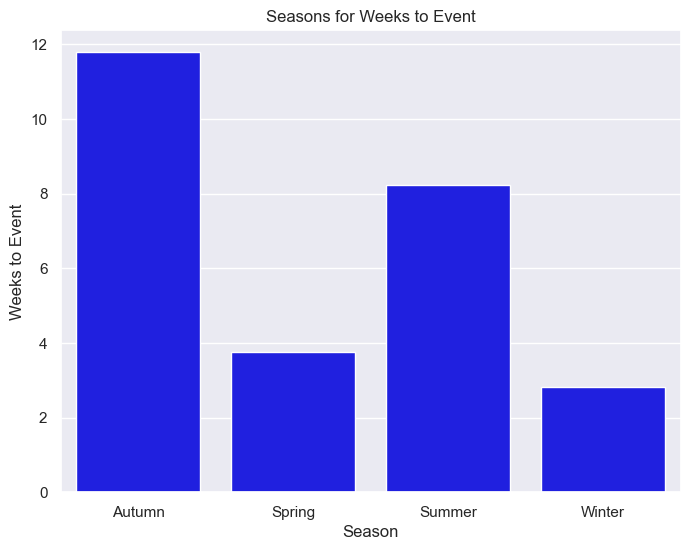

In [19]:
result1 = client_data.groupby(['Season'], as_index=False).agg({'Weeks to Event':'mean'})

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x = 'Season', y = 'Weeks to Event',data= result1, color='blue')
# ax.tick_params(axis='x', rotation=90)
ax.set_title('Seasons for Weeks to Event')

### For all event types, what is the average weeks to event for bookings made per month ?

Text(0.5, 1.0, 'Booking Months to Days to Event')

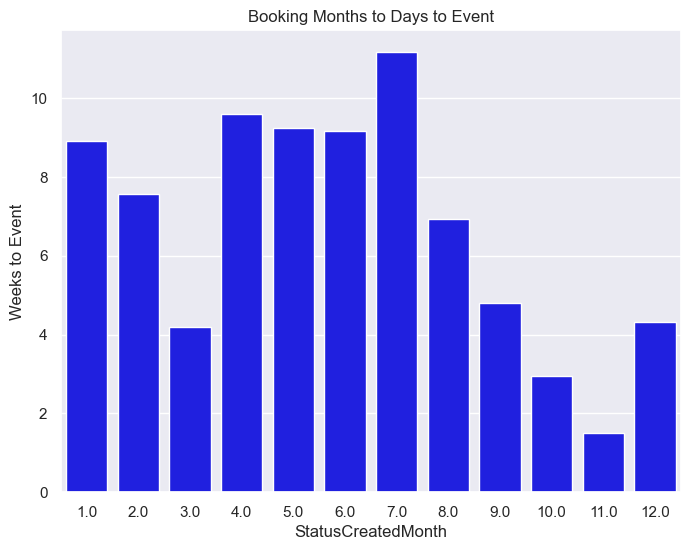

In [23]:
result2 = client_data['StatusCreatedMonth'] = client_data['StatusCreatedDate'].dt.month

result2 = client_data.groupby(['StatusCreatedMonth'], as_index=False).agg({'Weeks to Event':'mean'})

sns.set(rc={'figure.figsize':(8,6)})
ax = sns.barplot(x = 'StatusCreatedMonth', y = 'Weeks to Event',data= result2, color='blue')
# ax.tick_params(axis='x', rotation=90)
ax.set_title('Booking Months to Days to Event')

### For all event types, what are the weeks to event for number of bookings made ?

Text(0.5, 1.0, 'Number of Bookings made per Weeks to Event')

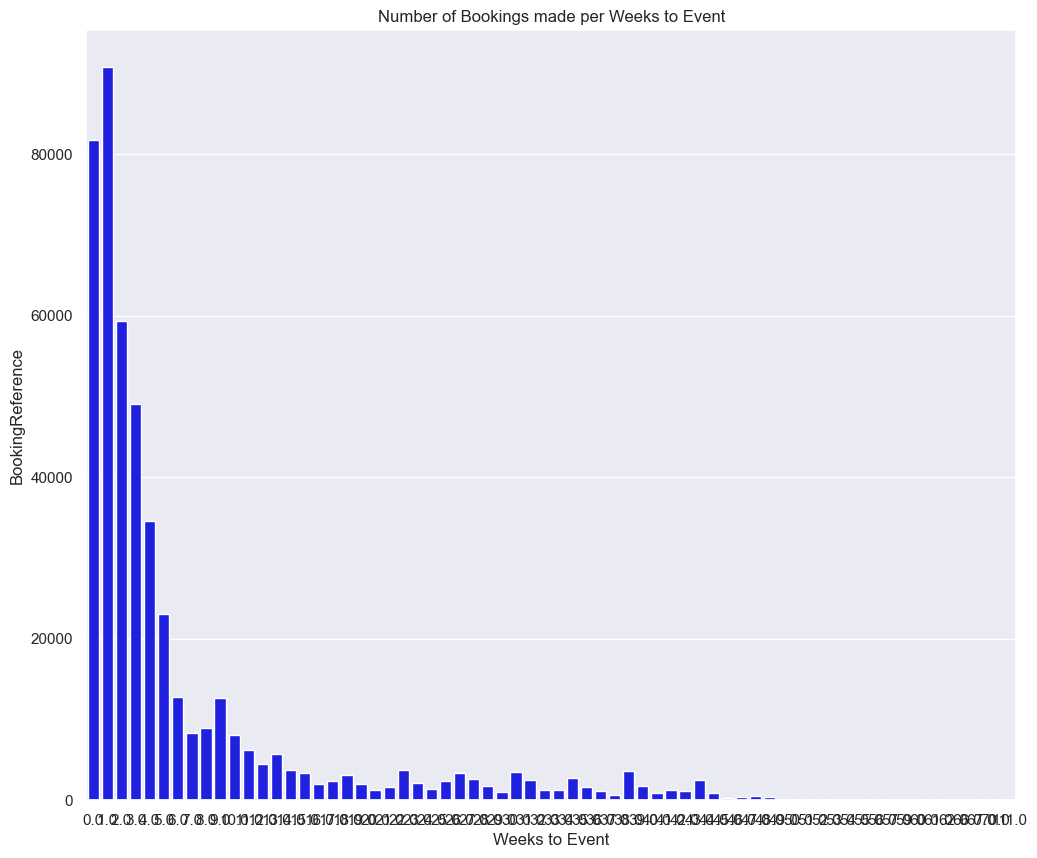

In [21]:
result3 = client_data.groupby(['Weeks to Event'], as_index=False).agg({'BookingReference':'count'})

sns.set(rc={'figure.figsize':(12,10)})
ax = sns.barplot(x = 'Weeks to Event', y = 'BookingReference',data= result3, color='blue')
# ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of Bookings made per Weeks to Event')

###  For categorized event types against weeks to event and BookingReference, what are the average weeks to event for number of bookings made ?

Text(0.5, 1.0, 'Number of Bookings made per Average Weeks to Event')

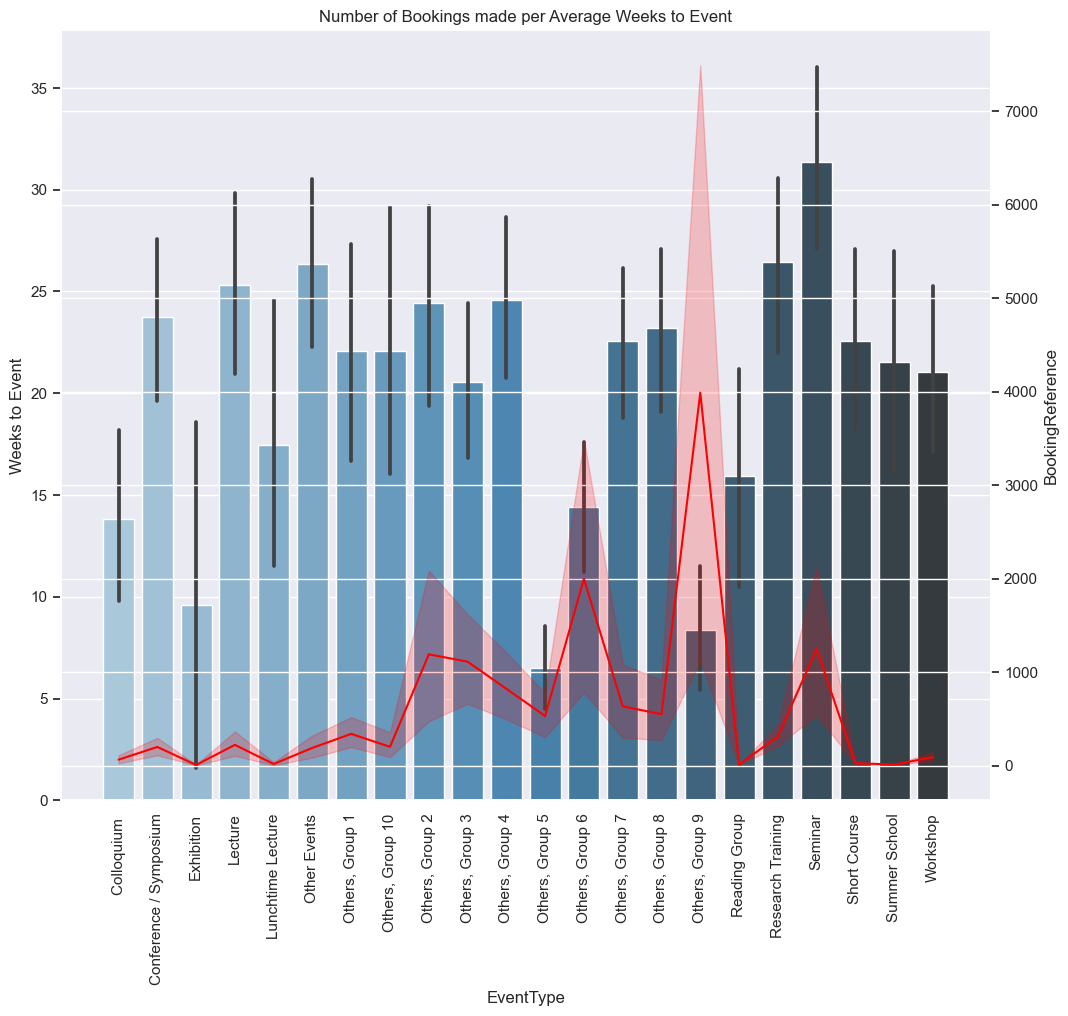

In [22]:
result4 = client_data.groupby(['EventType','Weeks to Event'], as_index=False).agg({'BookingReference':'count'})

sns.set(rc={'figure.figsize':(12,10)})
ax = sns.barplot(x = 'EventType', y = 'Weeks to Event',data= result4, palette="Blues_d")
ax2 =ax.twinx()
ax3 = sns.lineplot(x='EventType', y= 'BookingReference', data=result4, color='red', markers=True, ax=ax2)
ax.tick_params(axis='x', rotation=90)
# ax.tick_params(axis='x', rotation=90)
ax.set_title('Number of Bookings made per Average Weeks to Event')